# Import Libraries

In [2]:
from tensorflow.keras import models
from tensorflow.keras import layers
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image
from tensorflow.keras.utils import load_img, img_to_array

# Preprocessing

Load environment variables (not needed at the moment) and dataframe (csv.file)

In [3]:
MODEL_TARGET = os.environ.get('MODEL_TARGET')
GCP_PROJECT = os.environ.get('GCP_PROJECT')
GCP_REGION = os.environ.get('GCP_REGION')

BUCKET_NAME = os.environ.get('BUCKET_NAME')
BQ_REGION = os.environ.get('BQ_REGION')
BQ_DATASET = os.environ.get('BQ_DATASET')
PLATE_NUMBER = os.environ.get('PLATE_NUMBER')

LOCAL_DATA_PATH = os.path.join(os.path.expanduser('~'), ".morpho_minds_data")

In [4]:
data_df = pd.read_csv(os.path.join(LOCAL_DATA_PATH, PLATE_NUMBER, 'processed', f'{PLATE_NUMBER}_small.csv'))
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2304 entries, 0 to 2303
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PhGolgi      2304 non-null   object 
 1   Hoechst      2304 non-null   object 
 2   ERSyto       2304 non-null   object 
 3   Mito         2304 non-null   object 
 4   ERSytoBleed  2304 non-null   object 
 5   CellCount    2304 non-null   int64  
 6   Well         2304 non-null   object 
 7   PhotoNumber  2304 non-null   int64  
 8   Role         2304 non-null   object 
 9   MMoles       2304 non-null   float64
 10  Plate        2304 non-null   int64  
 11  MeanArea     2304 non-null   float64
dtypes: float64(2), int64(3), object(7)
memory usage: 216.1+ KB


# Very Basic Model to Setup (Simpliest Model)

This model uses only 1 channel and is the simpliest way to use the model. In this model no conversion to 8-bit was done!

In [5]:
paths_df = data_df['PhGolgi'].map(lambda x: str(Path(LOCAL_DATA_PATH).joinpath(PLATE_NUMBER, 'raw', 'pictures', f'{PLATE_NUMBER}-Ph_golgi', x.split('/')[-1])))

In [6]:
channel_image_files = {'channel' : []}
channel_images = {'channel' : []}

for path in paths_df:

    channel_image_files['channel'].append(path)

    img = load_img(path, target_size=(224, 224), color_mode='grayscale')
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)

    channel_images['channel'].append(img_array_expanded)

images_batch = np.vstack(channel_images['channel'])

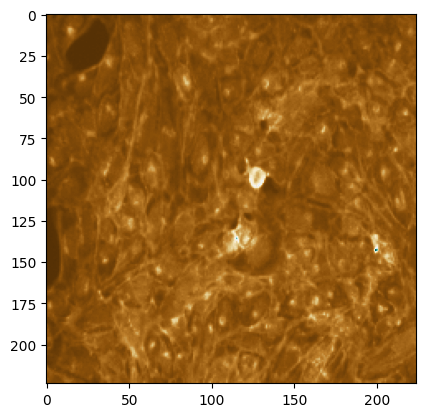

In [7]:
#images_batch/=65535
plt.imshow(images_batch[0, :, :, 0], cmap='BrBG')

In [41]:
X_train, X_test, y_train, y_test = train_test_split(images_batch, data_df['MeanArea'], test_size=0.2, random_state=42)

In [8]:
base_model_score = np.sum((data_df['MeanArea'] - data_df['MeanArea'].mean())**2)/data_df.shape[0]
base_model_score

357186.6667341978

In [65]:
def initialize_model():

    model = models.Sequential()
    model.add(layers.Conv2D(16, kernel_size=(4,4), activation = 'relu', input_shape = (224,224,1)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, kernel_size=(3,3), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, kernel_size=(2,2), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(32, kernel_size=(2,2), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(10, activation='relu'))

    model.add(layers.Dense(1, activation='linear'))

    model.compile(loss='mse',
                  optimizer='adam',
                  metrics='mae')

    return model

In [66]:
model = initialize_model()
es = EarlyStopping(patience = 15, restore_best_weights = True)

history = model.fit(X_train,
                    y_train,
                    validation_split = 0.3,
                    batch_size = 32,
                    epochs = 100,
                    callbacks = [es],
                    verbose = 1)

Epoch 1/100
41/41 [==============================] - 12s 289ms/step - loss: 1449935.6250 - mae: 902.5494 - val_loss: 814595.6250 - val_mae: 732.5516
Epoch 2/100
41/41 [==============================] - 13s 317ms/step - loss: 832067.9375 - mae: 698.9511 - val_loss: 951176.8125 - val_mae: 734.5804
Epoch 3/100
41/41 [==============================] - 12s 286ms/step - loss: 787445.3750 - mae: 678.1820 - val_loss: 904771.6250 - val_mae: 758.6349
Epoch 4/100
41/41 [==============================] - 11s 258ms/step - loss: 761190.8125 - mae: 668.8503 - val_loss: 805852.3750 - val_mae: 694.4277
Epoch 5/100
41/41 [==============================] - 12s 285ms/step - loss: 656738.6875 - mae: 620.2170 - val_loss: 883223.1875 - val_mae: 711.4506
Epoch 6/100
41/41 [==============================] - 12s 284ms/step - loss: 623710.9375 - mae: 600.0674 - val_loss: 833923.1875 - val_mae: 707.8376
Epoch 7/100
41/41 [==============================] - 11s 277ms/step - loss: 602347.9375 - mae: 593.8371 - val_l

In [67]:
model.evaluate(X_test, y_test)

15/15 [==============================] - 1s 55ms/step - loss: 530695.0000 - mae: 551.9249


[530695.0, 551.9249267578125]

1640    1943.209677
508     3089.558824
1422    2532.900901
44      1169.848485
1398    2023.597015
           ...     
1825    2632.601852
1674    2036.045455
1813    2107.811475
1776    2073.785185
2227    2700.059406
Name: MeanArea, Length: 461, dtype: float64

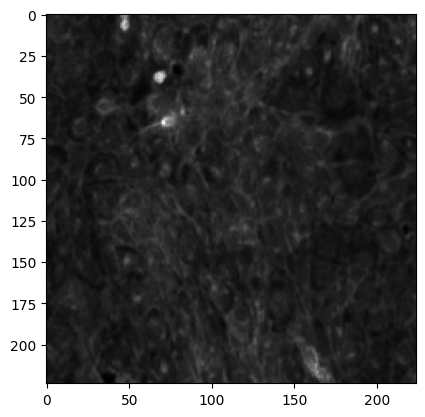

In [68]:
plt.imshow(X_test[0], cmap='gray')
y_test

In [69]:
model.predict(X_test[0].reshape(1, 224, 224, 1))

1/1 [==============================] - 0s 44ms/step


array([[2028.87]], dtype=float32)

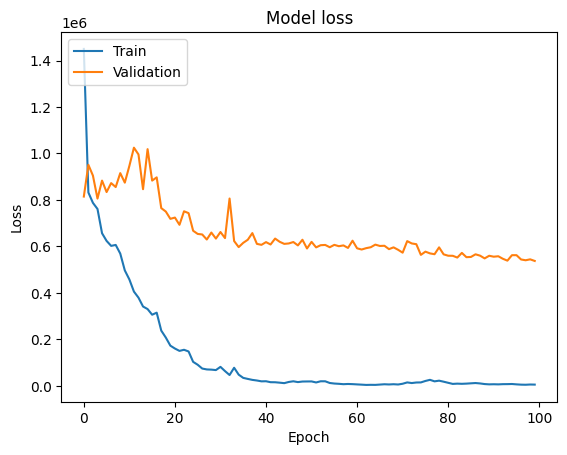

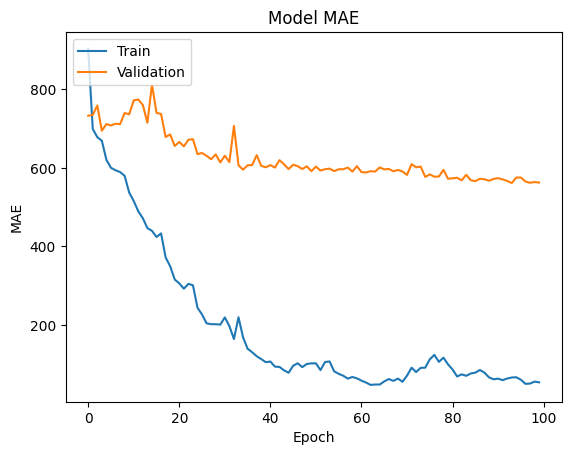

In [70]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation metrics (e.g., MAE)
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Plot learning curves for the model trained with data from both channels
plot_learning_curves(history)

# Model using not PhGolgi but ERSytoBleed as channel

In [71]:
paths_df = data_df['ERSytoBleed'].map(lambda x: str(Path(LOCAL_DATA_PATH).joinpath(PLATE_NUMBER, 'raw', 'pictures', f'{PLATE_NUMBER}-ERSytoBleed', x.split('/')[-1])))
channel_image_files = {'channel' : []}
channel_images = {'channel' : []}

for path in paths_df:

    channel_image_files['channel'].append(path)

    img = load_img(path, target_size=(224, 224), color_mode='grayscale')
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)

    channel_images['channel'].append(img_array_expanded)

images_batch = np.vstack(channel_images['channel'])

X_train, X_test, y_train, y_test = train_test_split(images_batch, data_df['MeanArea'], test_size=0.2, random_state=42)

def initialize_model():

    model = models.Sequential()
    model.add(layers.Conv2D(16, kernel_size=(4,4), activation = 'relu', input_shape = (224,224,1)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, kernel_size=(3,3), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, kernel_size=(2,2), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(128, kernel_size=(2,2), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(20, activation='relu'))

    model.add(layers.Dense(1, activation='linear'))

    model.compile(loss='mse',
                  optimizer='adam',
                  metrics='mae')

    return model

model = initialize_model()
es = EarlyStopping(patience = 15, restore_best_weights = True)

history = model.fit(X_train,
                    y_train,
                    validation_split = 0.3,
                    batch_size = 32,
                    epochs = 100,
                    callbacks = [es],
                    verbose = 1)


Epoch 1/100
41/41 [==============================] - 12s 275ms/step - loss: 1215874.3750 - mae: 847.6929 - val_loss: 800389.1250 - val_mae: 734.4622
Epoch 2/100
41/41 [==============================] - 11s 273ms/step - loss: 839878.1250 - mae: 707.1824 - val_loss: 854968.8125 - val_mae: 775.5400
Epoch 3/100
41/41 [==============================] - 11s 272ms/step - loss: 815567.0000 - mae: 705.9307 - val_loss: 772136.2500 - val_mae: 697.1923
Epoch 4/100
41/41 [==============================] - 11s 269ms/step - loss: 798660.3750 - mae: 689.6260 - val_loss: 1024411.0625 - val_mae: 747.2167
Epoch 5/100
41/41 [==============================] - 12s 305ms/step - loss: 784477.6875 - mae: 694.4791 - val_loss: 747427.9375 - val_mae: 690.3624
Epoch 6/100
41/41 [==============================] - 13s 312ms/step - loss: 683566.4375 - mae: 643.6883 - val_loss: 738965.8750 - val_mae: 701.6400
Epoch 7/100
41/41 [==============================] - 11s 276ms/step - loss: 651506.9375 - mae: 630.1454 - val_

In [72]:
model.evaluate(X_test, y_test)

15/15 [==============================] - 1s 57ms/step - loss: 434611.7812 - mae: 496.9431


[434611.78125, 496.9431457519531]

1640    1943.209677
508     3089.558824
1422    2532.900901
44      1169.848485
1398    2023.597015
           ...     
1825    2632.601852
1674    2036.045455
1813    2107.811475
1776    2073.785185
2227    2700.059406
Name: MeanArea, Length: 461, dtype: float64

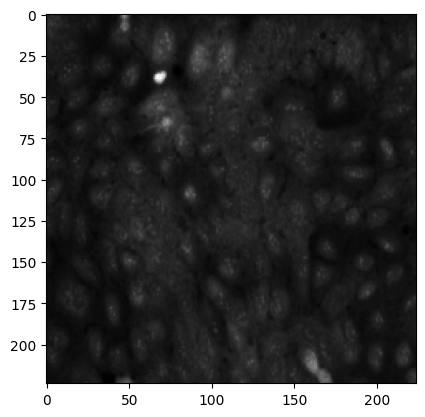

In [73]:
plt.imshow(X_test[0], cmap='gray')
y_test

In [74]:
model.predict(X_test[0].reshape(1, 224, 224, 1))

1/1 [==============================] - 0s 47ms/step


array([[2198.6187]], dtype=float32)

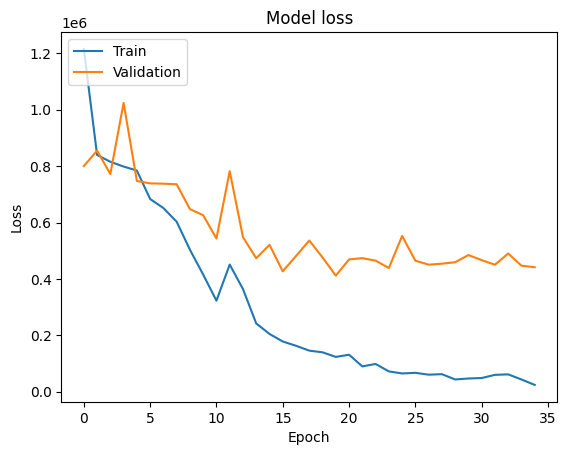

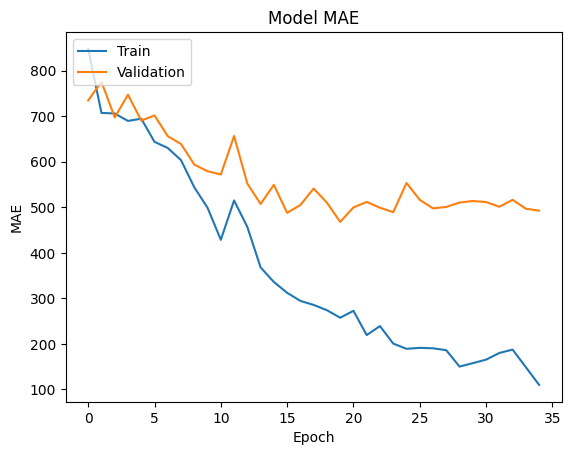

In [75]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation metrics (e.g., MAE)
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Plot learning curves for the model trained with data from both channels
plot_learning_curves(history)

# Model with 2 Channels and 1 plate trained (getting better :) )

In [9]:
# Load paths for images from the PhGolgi channel
paths_df_phgolgi = data_df['PhGolgi'].map(lambda x: str(Path(LOCAL_DATA_PATH).joinpath(PLATE_NUMBER, 'raw', 'pictures', f'{PLATE_NUMBER}-Ph_golgi', x.split('/')[-1])))
paths_df_Hoechst = data_df['Hoechst'].map(lambda x: str(Path(LOCAL_DATA_PATH).joinpath(PLATE_NUMBER, 'raw', 'pictures', f'{PLATE_NUMBER}-Hoechst', x.split('/')[-1])))

# Initialize dictionaries to hold file paths and images for both channels
channel_image_files_both = {'ERSytoBleed': [], 'Ph_golgi': [], 'Hoechst':[]}
channel_images_both = {'ERSytoBleed': [], 'Ph_golgi': [], 'Hoechst':[]}

# Loop through paths and load images for the ERSytoBleed channel
for path in paths_df:
    channel_image_files_both['ERSytoBleed'].append(path)

    img = load_img(path, target_size=(224, 224), color_mode='grayscale')
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)

    channel_images_both['ERSytoBleed'].append(img_array_expanded)

# Loop through paths and load images for the PhGolgi channel
for path in paths_df_phgolgi:
    channel_image_files_both['Ph_golgi'].append(path)

    img = load_img(path, target_size=(224, 224), color_mode='grayscale')
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)

    channel_images_both['Ph_golgi'].append(img_array_expanded)

# for path in paths_df_Hoechst:
#     channel_image_files_both['Hoechst'].append(path)

#     img = load_img(path, target_size=(224, 224), color_mode='grayscale')
#     img_array = img_to_array(img)
#     img_array_expanded = np.expand_dims(img_array, axis=0)

#     channel_images_both['Hoechst'].append(img_array_expanded)

# Stack images to create a batch for each channel
images_batch_ersyto = np.vstack(channel_images_both['ERSytoBleed'])
images_batch_phgolgi = np.vstack(channel_images_both['Ph_golgi'])
# images_batch_hoechst = np.vstack(channel_images_both['Hoechst'])

# Combine images from both channels along the channel axis
images_batch_both = np.concatenate((images_batch_ersyto, images_batch_phgolgi), axis=-1)
images_batch_both.shape

X_train_both, X_test_both, y_train_both, y_test_both = train_test_split(images_batch_both, data_df['MeanArea'], test_size=0.2, random_state=42)
X_train_both.shape, X_test_both.shape, y_train_both.shape, y_test_both.shape

((1843, 224, 224, 2), (461, 224, 224, 2), (1843,), (461,))

In [11]:
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

def initialize_model():

    model = models.Sequential()
    model.add(layers.Conv2D(16, kernel_size=(4,4), activation = 'relu', input_shape = (224,224,2)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, kernel_size=(3,3), activation = 'relu'))
    #model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, kernel_size=(2,2), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(128, kernel_size=(2,2), activation = 'relu'))
    #model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(20, activation='relu'))

    model.add(layers.Dense(1, activation='linear'))

    initial_learning_rate = 0.01
    optimizer = Adam(learning_rate=initial_learning_rate)
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics='mae')

    return model

model = initialize_model()
es = EarlyStopping(patience = 15, restore_best_weights = True)

history = model.fit(X_train_both,
                    y_train_both,
                    validation_split = 0.3,
                    batch_size = 32,
                    epochs = 500,
                    callbacks = [es],
                    verbose = 1)


Epoch 1/500
41/41 [==============================] - 20s 476ms/step - loss: 2430086656.0000 - mae: 10459.1221 - val_loss: 996171.2500 - val_mae: 745.0629
Epoch 2/500
41/41 [==============================] - 19s 454ms/step - loss: 28552674.0000 - mae: 2955.0820 - val_loss: 806162.5000 - val_mae: 692.7647
Epoch 3/500
41/41 [==============================] - 18s 448ms/step - loss: 497501.6562 - mae: 565.9771 - val_loss: 350650.4062 - val_mae: 488.5956
Epoch 4/500
41/41 [==============================] - 18s 445ms/step - loss: 356514.4688 - mae: 486.0217 - val_loss: 353844.0625 - val_mae: 485.2662
Epoch 5/500
41/41 [==============================] - 19s 458ms/step - loss: 356310.0312 - mae: 486.0458 - val_loss: 353044.0938 - val_mae: 483.4790
Epoch 6/500
41/41 [==============================] - 18s 444ms/step - loss: 352392.9375 - mae: 483.5351 - val_loss: 374241.1562 - val_mae: 477.2980
Epoch 7/500
41/41 [==============================] - 18s 445ms/step - loss: 345776.5000 - mae: 475.0863

In [13]:
model.evaluate(X_test_both, y_test_both)
print(base_model_score)

15/15 [==============================] - 2s 106ms/step - loss: 334029.5938 - mae: 468.7737
357186.6667341978


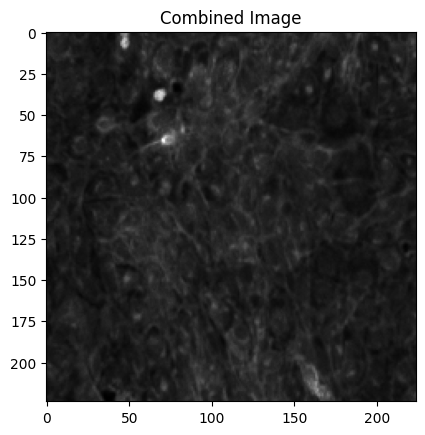

1640    1943.209677
508     3089.558824
1422    2532.900901
44      1169.848485
1398    2023.597015
           ...     
1825    2632.601852
1674    2036.045455
1813    2107.811475
1776    2073.785185
2227    2700.059406
Name: MeanArea, Length: 461, dtype: float64

In [15]:
combined_image = (X_test_both[0][:, :, 0] + X_test_both[0][:, :, 1]) / 2.0

plt.imshow(combined_image, cmap='gray')
plt.title('Combined Image')
plt.show()
y_test_both

In [18]:
model.predict(X_test_both[0].reshape(1, 224, 224, 2))

1/1 [==============================] - 0s 83ms/step


array([[2540.3782]], dtype=float32)

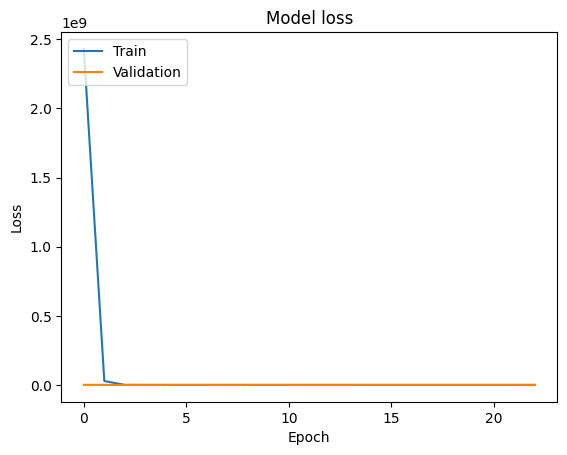

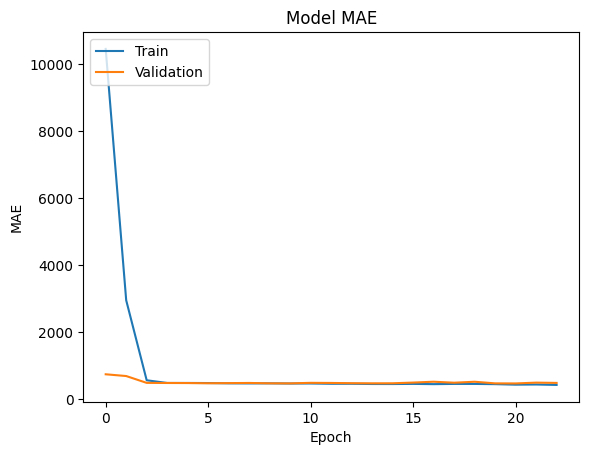

In [19]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation metrics (e.g., MAE)
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Plot learning curves for the model trained with data from both channels
plot_learning_curves(history)

# Model with 2 plates trained and using two channels (PhGolgi and ERSytoBleed)

This model uses now 2 plates (more training data) and 2 channels (ERSytoBleed is a good one)
Furthermore don't use 24277. This plate destroys the learning completely (probably there are to many wells with dead cells inside).


In [6]:
plates = ['24585','24639'] #'24277'

all_data_dfs = []
paths_df_phgolgi = []
#paths_df_Hoechst = []
paths_df_ERSytoBleed = []
for platenr in plates:
    data_df = pd.read_csv(os.path.join(LOCAL_DATA_PATH, platenr, 'processed', f'{platenr}_small.csv'))
    data_df['Plate'] = platenr
    all_data_dfs.append(data_df)
    paths_df_phgolgi.extend(
        data_df['PhGolgi'].map(lambda x: str(Path(LOCAL_DATA_PATH).joinpath(platenr, 'raw', 'pictures', f'{platenr}-Ph_golgi', x.split('/')[-1]))).tolist()
        )
    #paths_df_Hoechst.extend(
    #data_df['Hoechst'].map(lambda x: str(Path(LOCAL_DATA_PATH).joinpath(platenr, 'raw', 'pictures', f'{platenr}-Hoechst', x.split('/')[-1]))).tolist()
    #)
    paths_df_ERSytoBleed.extend(
    data_df['ERSytoBleed'].map(lambda x: str(Path(LOCAL_DATA_PATH).joinpath(platenr, 'raw', 'pictures', f'{platenr}-ERSytoBleed', x.split('/')[-1]))).tolist()
    )
concatenated_df = pd.concat(all_data_dfs, ignore_index=True)

In [7]:
# Initialize dictionaries to hold file paths and images for multip channels
channel_image_files_multip = {'ERSytoBleed': [], 'Ph_golgi': []}
channel_images_mp = {'ERSytoBleed': [], 'Ph_golgi': []}

# Loop through paths and load images for the ERSytoBleed channel
for path in paths_df_ERSytoBleed:
    channel_image_files_multip['ERSytoBleed'].append(path)

    img = load_img(path, target_size=(224, 224), color_mode='grayscale')
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)

    channel_images_mp['ERSytoBleed'].append(img_array_expanded)

# Loop through paths and load images for the PhGolgi channel
for path in paths_df_phgolgi:
    channel_image_files_multip['Ph_golgi'].append(path)

    img = load_img(path, target_size=(224, 224), color_mode='grayscale')
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)

    channel_images_mp['Ph_golgi'].append(img_array_expanded)

# for path in paths_df_Hoechst:
#     channel_image_files_multip['Hoechst'].append(path)

#     img = load_img(path, target_size=(224, 224), color_mode='grayscale')
#     img_array = img_to_array(img)
#     img_array_expanded = np.expand_dims(img_array, axis=0)

#     channel_images_mp['Hoechst'].append(img_array_expanded)

# Stack images to create a batch for each channel
images_batch_ersyto = np.vstack(channel_images_mp['ERSytoBleed'])
images_batch_phgolgi = np.vstack(channel_images_mp['Ph_golgi'])
#images_batch_hoechst = np.vstack(channel_images_mp['Hoechst'])

# Combine images from multip channels along the channel axis
images_batch_multip = np.concatenate((images_batch_ersyto, images_batch_phgolgi), axis=-1)
images_batch_multip.shape


(4606, 224, 224, 2)

In [8]:
images_batch_multip = images_batch_multip/65535

In [9]:
X_train_mp, X_test_mp, y_train_mp, y_test_mp = train_test_split(images_batch_multip, concatenated_df['MeanArea'], test_size=0.2, random_state=42, shuffle=True)
X_train_mp.shape, X_test_mp.shape, y_train_mp.shape, y_test_mp.shape

((3684, 224, 224, 2), (922, 224, 224, 2), (3684,), (922,))

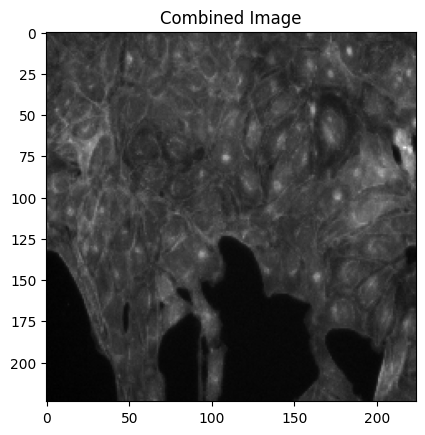

3647    2764.402062
4299    4634.466667
3534    2951.275862
240     2640.329897
3500    2690.694737
           ...     
2274    3214.580247
1881    2416.009091
2759    3472.259740
1814    2019.031746
1839    2984.736842
Name: MeanArea, Length: 922, dtype: float64

In [10]:
combined_image = (X_test_mp[0][:, :, 0] + X_test_mp[0][:, :, 1]) / 2.0  # + X_test_trip[0][:,:,2]

plt.imshow(combined_image, cmap='gray')
plt.title('Combined Image')
plt.show()
y_test_mp

In [12]:
### This are now 2 plates (without 24277) and two channels only normalized to 8 bit!

from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

def initialize_model():

    model = models.Sequential()
    model.add(layers.Conv2D(16, kernel_size=(4,4), activation = 'relu', input_shape = (224,224,2)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, kernel_size=(3,3), activation = 'relu'))
    #model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, kernel_size=(2,2), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(128, kernel_size=(2,2), activation = 'relu'))
    #model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(20, activation='relu'))

    model.add(layers.Dense(1, activation='linear'))

    initial_learning_rate = 0.01
    optimizer = Adam(learning_rate=initial_learning_rate)
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics='mae')

    return model

model = initialize_model()
es = EarlyStopping(patience = 12, restore_best_weights = True)

history = model.fit(X_train_mp,
                    y_train_mp,
                    validation_split = 0.3,
                    batch_size = 32,
                    epochs = 500,
                    callbacks = [es],
                    verbose = 1)


Epoch 1/500
81/81 [==============================] - 46s 568ms/step - loss: 796399.3125 - mae: 651.2484 - val_loss: 289864.5625 - val_mae: 389.8146
Epoch 2/500
81/81 [==============================] - 60s 739ms/step - loss: 203391.0938 - mae: 324.9384 - val_loss: 185994.7969 - val_mae: 307.2273
Epoch 3/500
81/81 [==============================] - 55s 675ms/step - loss: 218778.1406 - mae: 345.6548 - val_loss: 175864.4375 - val_mae: 281.8134
Epoch 4/500
81/81 [==============================] - 55s 672ms/step - loss: 220099.1250 - mae: 350.1237 - val_loss: 182331.3281 - val_mae: 288.7408
Epoch 5/500
81/81 [==============================] - 50s 615ms/step - loss: 182557.2812 - mae: 311.9443 - val_loss: 188913.7969 - val_mae: 299.7962
Epoch 6/500
81/81 [==============================] - 43s 533ms/step - loss: 187125.0938 - mae: 316.7919 - val_loss: 240132.8125 - val_mae: 362.2723
Epoch 7/500
81/81 [==============================] - 38s 469ms/step - loss: 199218.9062 - mae: 332.7018 - val_lo

In [13]:
model.save('model_2plates_2channels_8bit.keras')

In [24]:
base_model_score = np.sum((concatenated_df['MeanArea'] - concatenated_df['MeanArea'].mean())**2)/concatenated_df.shape[0]
base_model_mae = np.mean(np.abs(concatenated_df['MeanArea'] - concatenated_df['MeanArea'].mean()))
base_model_score, base_model_mae

(588344.6933516702, 632.8366518085261)

#### MODEL 1

In [15]:
### Model Comparison######
model.evaluate(X_test_mp, y_test_mp)
print(base_model_score, base_model_mae)

29/29 [==============================] - 4s 117ms/step - loss: 134164.7344 - mae: 273.5646
588344.6933516702


In [22]:
print(y_test_mp)
model.predict(X_test_mp[1].reshape(1, 224, 224, 2))


3647    2764.402062
4299    4634.466667
3534    2951.275862
240     2640.329897
3500    2690.694737
           ...     
2274    3214.580247
1881    2416.009091
2759    3472.259740
1814    2019.031746
1839    2984.736842
Name: MeanArea, Length: 922, dtype: float64
1/1 [==============================] - 0s 19ms/step


array([[3638.9397]], dtype=float32)

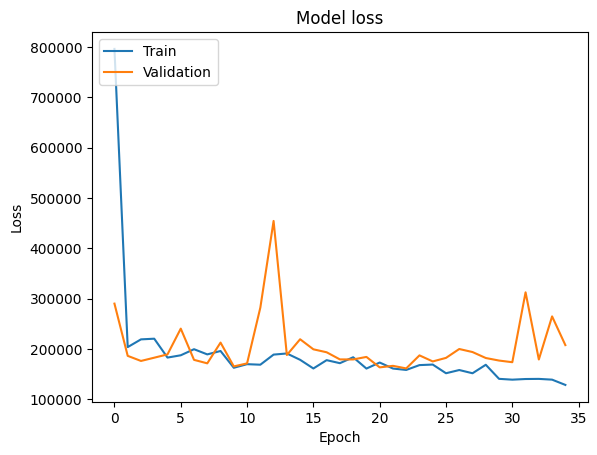

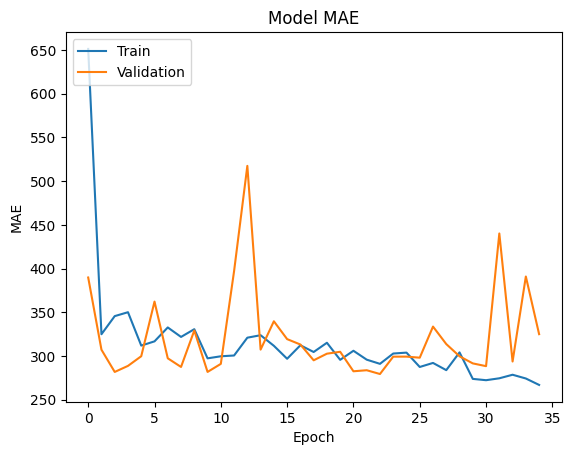

In [25]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation metrics (e.g., MAE)
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Plot learning curves for the model trained with data from both channels
plot_learning_curves(history)

# Final Model (i think it is the best)

This model uses 3 channels and 2 plates. Most comprehensive model. 

In [15]:

plates = ['24585','24639'] #'24277','24639'

all_data_dfs = []
paths_df_phgolgi = []
paths_df_third = []
paths_df_ERSytoBleed = []
for platenr in plates:
    data_df = pd.read_csv(os.path.join(LOCAL_DATA_PATH, platenr, 'processed', f'{platenr}_small.csv'))
    data_df['Plate'] = platenr
    all_data_dfs.append(data_df)
    paths_df_phgolgi.extend(
        data_df['PhGolgi'].map(lambda x: str(Path(LOCAL_DATA_PATH).joinpath(platenr, 'raw', 'pictures', f'{platenr}-Ph_golgi', x.split('/')[-1]))).tolist()
        )
    paths_df_third.extend(
    data_df['Hoechst'].map(lambda x: str(Path(LOCAL_DATA_PATH).joinpath(platenr, 'raw', 'pictures', f'{platenr}-Hoechst', x.split('/')[-1]))).tolist()
    )
    paths_df_ERSytoBleed.extend(
    data_df['ERSytoBleed'].map(lambda x: str(Path(LOCAL_DATA_PATH).joinpath(platenr, 'raw', 'pictures', f'{platenr}-ERSytoBleed', x.split('/')[-1]))).tolist()
    )
concatenated_df = pd.concat(all_data_dfs, ignore_index=True)

In [16]:
# Initialize dictionaries to hold file paths and images for multip channels
channel_image_files_multip = {'ERSytoBleed': [], 'Ph_golgi': [], 'ERSyto':[]}
channel_images_mp = {'ERSytoBleed': [], 'Ph_golgi': [], 'ERSyto':[]}

# Loop through paths and load images for the ERSytoBleed channel
for path in paths_df_ERSytoBleed:
    channel_image_files_multip['ERSytoBleed'].append(path)

    img = load_img(path, target_size=(224, 224), color_mode='grayscale')
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)

    channel_images_mp['ERSytoBleed'].append(img_array_expanded)

# Loop through paths and load images for the PhGolgi channel
for path in paths_df_phgolgi:
    channel_image_files_multip['Ph_golgi'].append(path)

    img = load_img(path, target_size=(224, 224), color_mode='grayscale')
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)

    channel_images_mp['Ph_golgi'].append(img_array_expanded)

for path in paths_df_third:
    channel_image_files_multip['ERSyto'].append(path)

    img = load_img(path, target_size=(224, 224), color_mode='grayscale')
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)

    channel_images_mp['ERSyto'].append(img_array_expanded)

# Stack images to create a batch for each channel
images_batch_ersyto = np.vstack(channel_images_mp['ERSytoBleed'])
images_batch_phgolgi = np.vstack(channel_images_mp['Ph_golgi'])
images_batch_third = np.vstack(channel_images_mp['ERSyto'])

# Combine images from multip channels along the channel axis
images_batch_multip = np.concatenate((images_batch_ersyto, images_batch_phgolgi,images_batch_third), axis=-1)
images_batch_multip.shape


(4606, 224, 224, 3)

In [17]:
images_batch_multip = images_batch_multip/65535

In [18]:
X_train_mp, X_test_mp, y_train_mp, y_test_mp = train_test_split(images_batch_multip, concatenated_df['MeanArea'], test_size=0.2, random_state=42, shuffle=True)
X_train_mp.shape, X_test_mp.shape, y_train_mp.shape, y_test_mp.shape

((3684, 224, 224, 3), (922, 224, 224, 3), (3684,), (922,))

In [19]:
from tensorflow.keras import regularizers

def initialize_model():

    model = models.Sequential()
    model.add(layers.Conv2D(16, kernel_size=(4,4), activation = 'relu', input_shape = (224,224,3)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, kernel_size=(3,3), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, kernel_size=(2,2), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(128, kernel_size=(2,2), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(20, activation='relu'))

    model.add(layers.Dense(1, activation='linear'))

    initial_learning_rate = 0.01
    optimizer = Adam(learning_rate=initial_learning_rate)
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics='mae')

    return model


In [20]:
from tensorflow.keras.optimizers.legacy import Adam
model = initialize_model()
es = EarlyStopping(patience = 10, restore_best_weights = True)

history = model.fit(X_train_mp,
                    y_train_mp,
                    validation_split = 0.3,
                    batch_size = 32,
                    epochs = 500,
                    callbacks = [es],
                    verbose = 1)


Epoch 1/500
81/81 [==============================] - 30s 369ms/step - loss: 1298717.6250 - mae: 847.1251 - val_loss: 1101617.8750 - val_mae: 838.3098
Epoch 2/500
81/81 [==============================] - 26s 324ms/step - loss: 331449.3750 - mae: 438.6115 - val_loss: 197323.2500 - val_mae: 310.7758
Epoch 3/500
81/81 [==============================] - 26s 325ms/step - loss: 179841.4688 - mae: 305.7634 - val_loss: 211661.6719 - val_mae: 308.2682
Epoch 4/500
81/81 [==============================] - 26s 323ms/step - loss: 199876.6562 - mae: 325.3368 - val_loss: 190129.7031 - val_mae: 287.6891
Epoch 5/500
81/81 [==============================] - 27s 337ms/step - loss: 193305.0938 - mae: 320.0484 - val_loss: 186020.1406 - val_mae: 281.1768
Epoch 6/500
81/81 [==============================] - 27s 337ms/step - loss: 193453.3750 - mae: 318.1982 - val_loss: 209032.6094 - val_mae: 305.4935
Epoch 7/500
81/81 [==============================] - 26s 325ms/step - loss: 181324.2812 - mae: 308.7709 - val_

In [21]:
model.save('model_2plate_ERSyto_ERSytobleed_Phgolgi_2024_03_13_before_lunch.keras')

In [22]:
base_model_score = np.sum((concatenated_df['MeanArea'] - concatenated_df['MeanArea'].mean())**2)/concatenated_df.shape[0]
base_model_mae = np.mean(np.abs(concatenated_df['MeanArea'] - concatenated_df['MeanArea'].mean()))
base_model_score

588344.6933516702

In [23]:
model.evaluate(X_test_mp, y_test_mp)
print(base_model_score, base_model_mae)

29/29 [==============================] - 3s 96ms/step - loss: 134765.1250 - mae: 263.6228
588344.6933516702 632.8366518085261


In [24]:
print(y_test_mp)
model.predict(X_test_mp[0].reshape(1, 224, 224, 3))

3647    2764.402062
4299    4634.466667
3534    2951.275862
240     2640.329897
3500    2690.694737
           ...     
2274    3214.580247
1881    2416.009091
2759    3472.259740
1814    2019.031746
1839    2984.736842
Name: MeanArea, Length: 922, dtype: float64
1/1 [==============================] - 0s 71ms/step


array([[3139.8362]], dtype=float32)

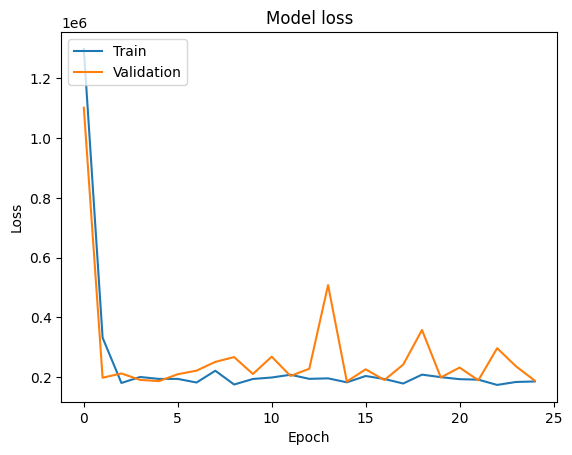

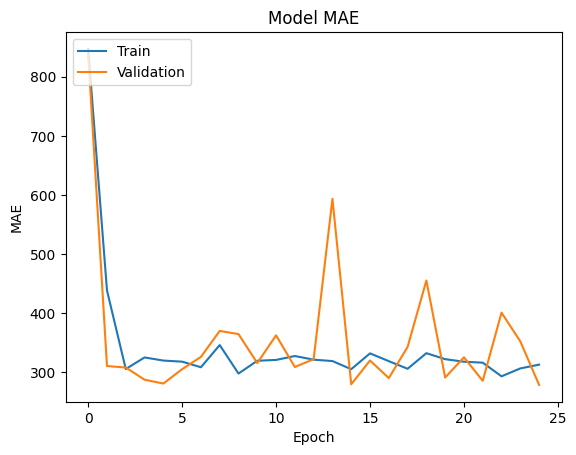

In [25]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation metrics (e.g., MAE)
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Plot learning curves for the model trained with data from both channels
plot_learning_curves(history)

In [35]:
model.layers[0].weights

[<tf.Variable 'conv2d_8/kernel:0' shape=(4, 4, 3, 16) dtype=float32, numpy=
 array([[[[-1.34568498e-01, -3.33877295e-01,  3.15279588e-02,
           -2.37676367e-01, -4.52468872e-01, -9.16798934e-02,
           -3.35002124e-01, -2.92921603e-01, -1.50080994e-01,
           -2.87676841e-01, -4.25026119e-01, -2.56759048e-01,
           -1.36123775e-02, -1.51849225e-01, -2.99547277e-02,
           -4.26048011e-01],
          [-9.23001021e-02, -3.07391644e-01, -1.45453541e-02,
           -6.86992630e-02, -2.00462431e-01, -8.56177360e-02,
           -2.60599554e-01, -1.76376387e-01, -1.39312446e-02,
           -2.21446559e-01, -3.27216893e-01, -3.53031397e-01,
           -7.13670403e-02, -6.30229339e-02, -1.60049900e-01,
           -4.08739507e-01],
          [-1.20401733e-01, -2.54863977e-01,  3.55293863e-02,
           -1.75110742e-01, -3.02146524e-01, -1.13456644e-01,
           -9.60505307e-02, -1.11836240e-01, -5.32885268e-02,
           -2.93969810e-01, -9.00636539e-02, -1.78119078e-01

In [51]:
model.layers

In [71]:
model.layers[2].weights[0]

<tf.Variable 'conv2d_9/kernel:0' shape=(3, 3, 16, 64) dtype=float32, numpy=
array([[[[-0.02211037,  0.00728554,  0.08511227, ...,  0.09230594,
          -0.06614599,  0.00978514],
         [ 0.1131703 , -0.026365  , -0.12296082, ...,  0.02934939,
          -0.06579602, -0.1020242 ],
         [-0.14406945, -0.10887586,  0.04663801, ...,  0.06289502,
          -0.10996891, -0.09588874],
         ...,
         [-0.03895484, -0.04325501,  0.09504828, ...,  0.07921103,
          -0.00371843, -0.07041194],
         [-0.11295141, -0.01652326, -0.06144177, ..., -0.07920172,
          -0.08635081, -0.01593272],
         [ 0.11232737, -0.10680746, -0.02839798, ...,  0.05807782,
          -0.12692268,  0.06516641]],

        [[-0.036999  ,  0.04537291, -0.09165301, ..., -0.02063365,
          -0.09909718, -0.04537199],
         [ 0.08226084,  0.02907817,  0.04801218, ...,  0.02761922,
          -0.14013739, -0.03811688],
         [ 0.04396864, -0.06909308,  0.1107246 , ...,  0.13924825,
         

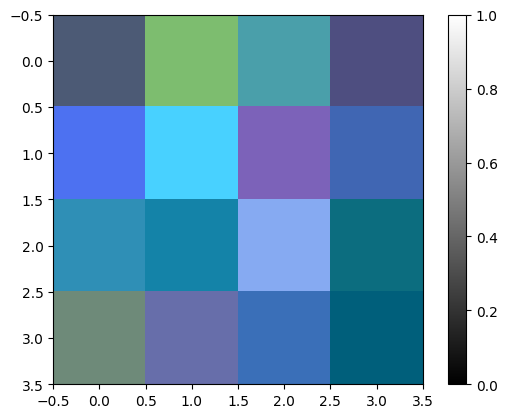

In [88]:
import matplotlib.pyplot as plt
import numpy as np

layer_1 = model.layers[0]
weights = layer_1.weights[0].numpy()  # Assuming you have the model and layer correctly referenced

# Normalize the filter weights
filter_weights = weights[:,:,:,1]  # Selecting the second filter for visualization
filter_weights_norm = (filter_weights - np.min(filter_weights)) / (np.max(filter_weights) - np.min(filter_weights))

# Plot the normalized filter weights
plt.imshow(filter_weights_norm, cmap='gray')
plt.colorbar()  # Optionally add a colorbar to see the mapping from weights to colors
plt.show()


In [86]:
filter_weights_norm
filter_weights

array([[[-0.3338773 , -0.30739164, -0.25486398],
        [-0.23841709, -0.11396366, -0.2657582 ],
        [-0.33829424, -0.17232397, -0.14997366],
        [-0.3313321 , -0.33054063, -0.23278046]],

       [[-0.33215073, -0.26267827, -0.01131717],
        [-0.34308535, -0.07545866,  0.01438465],
        [-0.23978297, -0.29175562, -0.12105071],
        [-0.35773778, -0.28304785, -0.13361762]],

       [[-0.39181778, -0.20380755, -0.12723586],
        [-0.4437668 , -0.22771959, -0.15389392],
        [-0.22189942, -0.14977702, -0.01091476],
        [-0.46016103, -0.27054754, -0.23565857]],

       [[-0.26710725, -0.21343178, -0.24700291],
        [-0.28087193, -0.267529  , -0.15143113],
        [-0.36928496, -0.26514167, -0.12372811],
        [-0.48395702, -0.2966753 , -0.24251072]]], dtype=float32)

In [84]:
filter_weights_norm2

array([[[0.55129075, 0.43720508, 0.15746781, 0.49810597, 0.16519217,
         0.69578624, 0.6353008 , 0.2162087 , 0.70325583, 0.1563213 ,
         0.42587733, 0.06922252, 0.49129114, 0.37994272, 0.47057158,
         0.16448031],
        [0.6804187 , 0.6251745 , 0.2923437 , 0.6155434 , 0.03587013,
         0.43578908, 0.04713053, 0.38393283, 0.5805814 , 0.25217173,
         0.6358952 , 0.36373514, 0.6389204 , 0.01559871, 0.63094527,
         0.45742932],
        [0.7715296 , 0.06905343, 0.6456251 , 0.5921557 , 0.13319117,
         0.7854776 , 0.5208481 , 0.55498016, 0.978958  , 0.28633243,
         0.25949505, 0.2477534 , 0.6976013 , 0.5662156 , 0.57310873,
         0.58575666]],

       [[0.07910187, 0.14892842, 0.40679166, 0.8130055 , 0.28279376,
         0.19557343, 0.51472026, 0.616453  , 0.8105235 , 0.38880572,
         0.3565286 , 0.42651364, 0.6773687 , 0.09427217, 0.5512303 ,
         0.24130438],
        [0.53814703, 0.28410187, 0.33778986, 0.46773458, 0.20686121,
         0.14

TypeError: Invalid shape (3, 3, 16) for image data

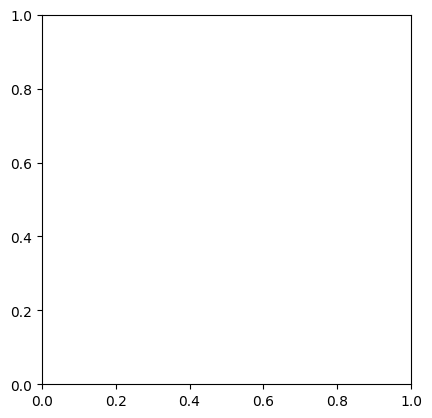

In [90]:

layer_2 = model.layers[2]
weights_2 = layer_2.weights[0].numpy()  # Assuming you have the model and layer correctly referenced

# Normalize the filter weights
filter_weights2 = weights_2[:,:,:,1]  # Selecting the second filter for visualization
filter_weights_norm2 = (filter_weights2 - np.min(filter_weights2)) / (np.max(filter_weights2) - np.min(filter_weights2))

# Plot the normalized filter weights
plt.imshow(filter_weights_norm2, cmap='grey')
plt.colorbar()  # Optionally add a colorbar to see the mapping from weights to colors
plt.show()


TypeError: Invalid shape (2, 2, 64) for image data

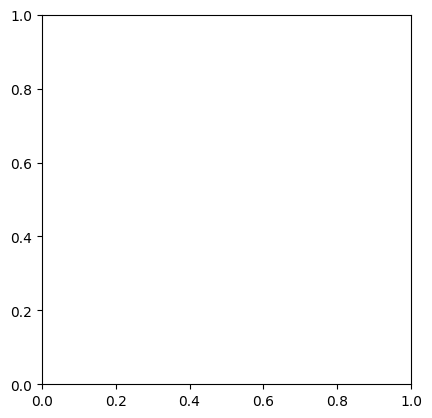

In [81]:

layer_3 = model.layers[4]
weights_3 = layer_3.weights[0].numpy()  # Assuming you have the model and layer correctly referenced

# Normalize the filter weights
filter_weights3 = weights_3[:,:,:,1]  # Selecting the second filter for visualization
filter_weights_norm3 = (filter_weights3 - np.min(filter_weights3)) / (np.max(filter_weights3) - np.min(filter_weights3))

# Plot the normalized filter weights
plt.imshow(filter_weights_norm3, cmap='grey')
plt.colorbar()  # Optionally add a colorbar to see the mapping from weights to colors
plt.show()


TypeError: Invalid shape (2, 2, 64) for image data

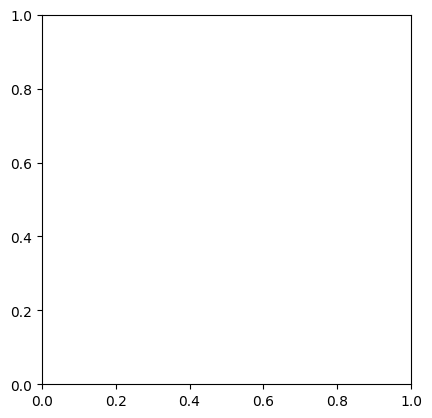

In [82]:

layer_4 = model.layers[6]
weights_4 = layer_4.weights[0].numpy()  # Assuming you have the model and layer correctly referenced

# Normalize the filter weights
filter_weights4 = weights_4[:,:,:,1]  # Selecting the second filter for visualization
filter_weights_norm4 = (filter_weights4 - np.min(filter_weights4)) / (np.max(filter_weights4) - np.min(filter_weights4))

# Plot the normalized filter weights
plt.imshow(filter_weights_norm4, cmap='grey')
plt.colorbar()  # Optionally add a colorbar to see the mapping from weights to colors
plt.show()

In [54]:
batch = X_train_mp[0:10]
activation_1 = layer_1(batch)
activation_1.shape
activation_2 = layer_2(batch)
activation_3 = layer_3(batch)
activation_4 = layer_4(batch)

ValueError: Input 0 of layer "conv2d_9" is incompatible with the layer: expected axis -1 of input shape to have value 16, but received input with shape (10, 224, 224, 3)

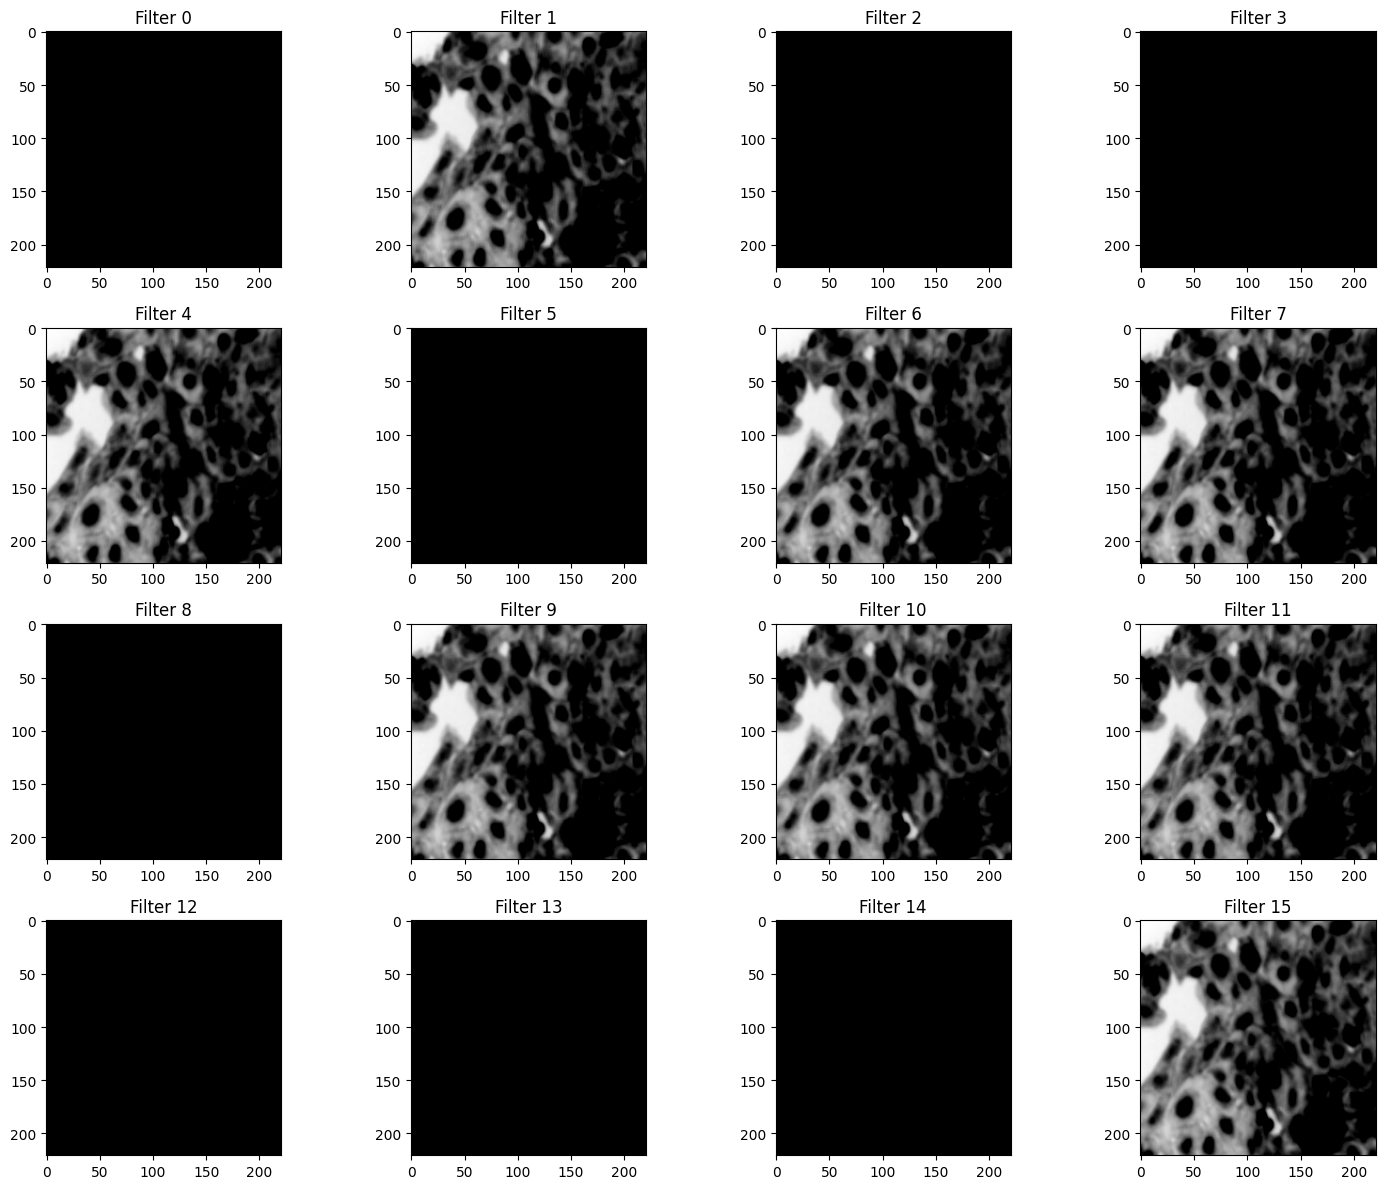

In [47]:
import matplotlib.pyplot as plt

# Assuming activation_1 has a shape [batch_size, height, width, num_filters]
# and you want to visualize the activation maps for all filters for the first image in the batch.

num_filters = activation_1.shape[3]  # This dynamically fetches the number of filters based on the layer output.
num_columns = 4  # Define how many columns you want in your subplot grid.
num_rows = num_filters // num_columns + (1 if num_filters % num_columns else 0)  # Calculate rows needed.

fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 3))  # Adjust figure size as needed.

for i in range(num_rows):
    for j in range(num_columns):
        ax = axs[i, j]
        filter_index = i * num_columns + j
        if filter_index < num_filters:
            feature_map = activation_1[0, :, :, filter_index]
            ax.imshow(feature_map, cmap='gray')
            ax.set_title(f'Filter {filter_index}')
        else:
            ax.axis('off')  # Turn off axis for plots without a filter to display.

plt.tight_layout()
plt.show()


# This is only BackupCode (thats why it is out commented)

In [ ]:
# # Initialize dictionaries to hold file paths and images for tripel channels
# channel_image_files_tripel = {'ERSytoBleed': [], 'Ph_golgi': [], 'Hoechst':[]}
# channel_images_trip = {'ERSytoBleed': [], 'Ph_golgi': [], 'Hoechst':[]}

# # Loop through paths and load images for the ERSytoBleed channel
# for path in paths_df_ERSytoBleed:
#     channel_image_files_tripel['ERSytoBleed'].append(path)

#     img = load_img(path, target_size=(224, 224), color_mode='grayscale')
#     img_array = img_to_array(img)
#     img_array_expanded = np.expand_dims(img_array, axis=0)

#     channel_images_trip['ERSytoBleed'].append(img_array_expanded)

# # Loop through paths and load images for the PhGolgi channel
# for path in paths_df_phgolgi:
#     channel_image_files_tripel['Ph_golgi'].append(path)

#     img = load_img(path, target_size=(224, 224), color_mode='grayscale')
#     img_array = img_to_array(img)
#     img_array_expanded = np.expand_dims(img_array, axis=0)

#     channel_images_trip['Ph_golgi'].append(img_array_expanded)

# for path in paths_df_Hoechst:
#     channel_image_files_tripel['Hoechst'].append(path)

#     img = load_img(path, target_size=(224, 224), color_mode='grayscale')
#     img_array = img_to_array(img)
#     img_array_expanded = np.expand_dims(img_array, axis=0)

#     channel_images_trip['Hoechst'].append(img_array_expanded)

# # Stack images to create a batch for each channel
# images_batch_ersyto = np.vstack(channel_images_trip['ERSytoBleed'])
# images_batch_phgolgi = np.vstack(channel_images_trip['Ph_golgi'])
# images_batch_hoechst = np.vstack(channel_images_trip['Hoechst'])

# # Combine images from tripel channels along the channel axis
# images_batch_tripel = np.concatenate((images_batch_ersyto, images_batch_phgolgi, images_batch_hoechst), axis=-1)
# images_batch_tripel.shape
